In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import warnings
import matplotlib.pyplot as plt

In [3]:
import numpy as np
import xarray as xr
import xbudget
import regionate
import xwmt
import xwmb
import xgcm
import CM4Xutils #needed to run pip install nc-time-axis

In [4]:
print('xgcm version', xgcm.__version__, '\nregionate version', regionate.__version__, '\nxwmt version', xwmt.__version__, '\nxwmb version', xwmb.__version__)

xgcm version 0.8.2.dev15+g7492277 
regionate version 0.0.1 
xwmt version 0.2.0 
xwmb version 0.2.0


### Request HPC Resources

In [5]:
from dask_jobqueue import SLURMCluster  # setup dask cluster 
cluster = SLURMCluster(
    cores=36,
    processes=1,
    memory='50GB',
    walltime='02:00:00',
    queue='compute',
    interface='ib0')
print(cluster.job_script())
cluster.scale(jobs=2)
from dask.distributed import Client
client = Client(cluster)
client

#!/usr/bin/env bash

#SBATCH -J dask-worker
#SBATCH -p compute
#SBATCH -n 1
#SBATCH --cpus-per-task=36
#SBATCH --mem=47G
#SBATCH -t 02:00:00

/vortexfs1/home/anthony.meza/miniforge3/envs/cm4x_analysis/bin/python -m distributed.cli.dask_worker tcp://172.16.3.58:35193 --name dummy-name --nthreads 36 --memory-limit 46.57GiB --nanny --death-timeout 60 --interface ib0



/vortexfs1/home/anthony.meza/miniforge3/envs/cm4x_analysis/lib/python3.12/site-packages/distributed/node.py:182: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 41193 instead
  warnings.warn(


Connection method: Cluster object,Cluster type: dask_jobqueue.SLURMCluster
Dashboard: /proxy/41193/status,
Dashboard: /proxy/41193/status,Workers: 0
Total threads: 0,Total memory: 0 B
Comm: tcp://172.16.3.58:35193,Workers: 0
Dashboard: /proxy/41193/status,Total threads: 0
Started: Just now,Total memory: 0 B


### Load in data

In [6]:
datadir = lambda x="" : "/vortexfs1/home/anthony.meza/scratch/CM4X/CM4XTransientTracers/data/" + x
ds = xr.open_mfdataset(
        datadir("CM4Xp125_budgets_sigma2_2020-2024.zarr"),
        data_vars="minimal",
        coords="minimal",
        compat="override",
        parallel=True,
        engine="zarr")
ds = ds.fillna(0.) #remove all NaNs

grid = CM4Xutils.ds_to_grid(ds, Zprefix = "sigma2")

In [7]:
grid._ds = grid._ds.assign_coords({
    "sigma2_l_target": grid._ds['sigma2_l'].rename({"sigma2_l":"sigma2_l_target"}),
    "sigma2_i_target": grid._ds['sigma2_i'].rename({"sigma2_i":"sigma2_i_target"}),
})
grid = xwmt.add_gridcoords(
    grid,
    {"Z_target": {"center": "sigma2_l_target", "outer": "sigma2_i_target"}},
    {"Z_target": "extend"}
)

In [8]:
name = "Labrador"
lons = np.array([-56.8775, -52.0956, -49.8604, -47.6107, -44.8000, -50,  -56.0, -61.5,  -63.5, -63.5])
lats = np.array([52.0166,   52.6648,  53.5577,  58.8944,  60.4000,  66.5, 66.5,  66.0,   66.0,  57.5])
region = regionate.GriddedRegion(name, lons, lats, grid)

### Collect budget terms and mass budget

In [9]:
with warnings.catch_warnings():
    warnings.simplefilter(action='ignore', category=FutureWarning)

    budgets_dict = xbudget.load_preset_budget(model="MOM6_3Donly")
    xbudget.collect_budgets(grid, budgets_dict)
    
    wmb = xwmb.WaterMassBudget(
        grid,
        budgets_dict, 
        region
    ) #if region not passed, the whole globe is taken
    wmb.mass_budget("sigma2", greater_than=True, default_bins=False, 
                    integrate=True, along_section=False)
    wmt = wmb.wmt

### Extract timemean mass budget

In [10]:
%time wmt_mean = (wmt.sel(exp="control").mean("time")/1035*1e-6).compute()

CPU times: user 1.2 s, sys: 262 ms, total: 1.46 s
Wall time: 51.9 s


### Plot time mean budget

In [11]:
def stairs(wmt, var, units="kg", **kwargs):
    da = wmt[var]
    coord = wmt[[c for c in wmt.coords if "l_target" in c][0]]
    coord_bounds = wmt[[c for c in wmt.coords if "i_target" in c][0]]
    l = plt.stairs(da, coord_bounds, **kwargs, orientation="horizontal")
    plt.xlabel(f"mean transformation rate [{units}]")
    return l

(-12.0, 18.0)

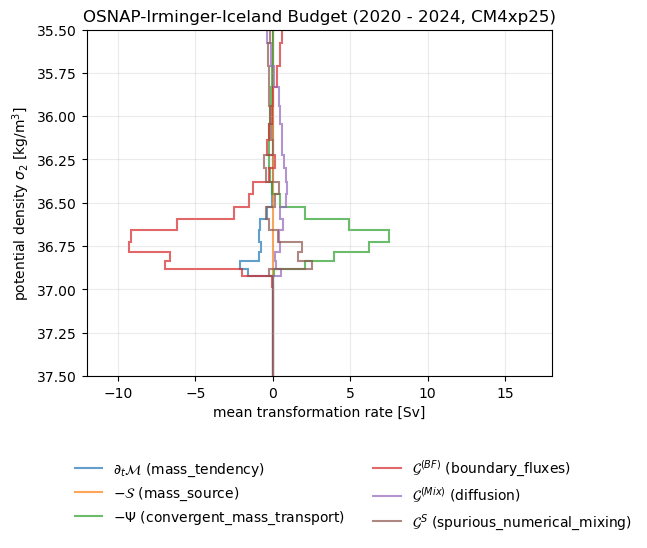

In [13]:
plt.figure(figsize=(6,4.5))

kwargs = {"units":"Sv", "alpha":0.7, "lw":1.5}

stairs(-wmt_mean, 'mass_tendency',             label=r"$\partial_{t} \mathcal{M}$ (mass_tendency)",**kwargs)
stairs(wmt_mean, 'mass_source',               label=r"$-\mathcal{S}$ (mass_source)",            **kwargs)
stairs(-wmt_mean, 'convergent_mass_transport', label=r"$-\Psi$ (convergent_mass_transport)",                   **kwargs)
stairs(-wmt_mean, 'boundary_fluxes',           label=r"$\mathcal{G}^{(BF)}$ (boundary_fluxes)",      **kwargs)
stairs(-wmt_mean, 'diffusion',                 label=r"$\mathcal{G}^{(Mix)}$ (diffusion)",     **kwargs)
stairs( -wmt_mean, 'spurious_numerical_mixing', label=r"$\mathcal{G}^{S}$ (spurious_numerical_mixing)", **kwargs)

plt.legend(loc="upper right", frameon = False, ncols = 2, bbox_to_anchor = (1.2, -0.2))
plt.grid(True, alpha=0.25)
plt.ylabel(r"potential density $\sigma_{2}$ [kg/m$^{3}$]");
plt.ylim( 37.5, 35.5,);
plt.title("OSNAP-Irminger-Iceland Budget (2020 - 2024, CM4xp25)")
plt.xlim(-12, 18)
